### **Import Libraries**

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Import Dataset and review**

In [19]:
def create_image_dataframe(base_path):
    data = []

    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                data.append({
                    "Image_Path": os.path.join(label_path, image),
                    "Image_Class": label
                })

    return pd.DataFrame(data)

In [20]:
train_df = create_image_dataframe('data/Training')
test_df = create_image_dataframe('data/Testing')

In [21]:
train_df.head()

,Image_Path,Image_Class
0,data/Training\glioma\Tr-glTr_0000.jpg,glioma
1,data/Training\glioma\Tr-glTr_0001.jpg,glioma
2,data/Training\glioma\Tr-glTr_0002.jpg,glioma
3,data/Training\glioma\Tr-glTr_0003.jpg,glioma
4,data/Training\glioma\Tr-glTr_0004.jpg,glioma


In [36]:
test_df.head()

,Image_Path,Image_Class
0,data/Testing\glioma\Te-glTr_0000.jpg,glioma
1,data/Testing\glioma\Te-glTr_0001.jpg,glioma
2,data/Testing\glioma\Te-glTr_0002.jpg,glioma
3,data/Testing\glioma\Te-glTr_0003.jpg,glioma
4,data/Testing\glioma\Te-glTr_0004.jpg,glioma


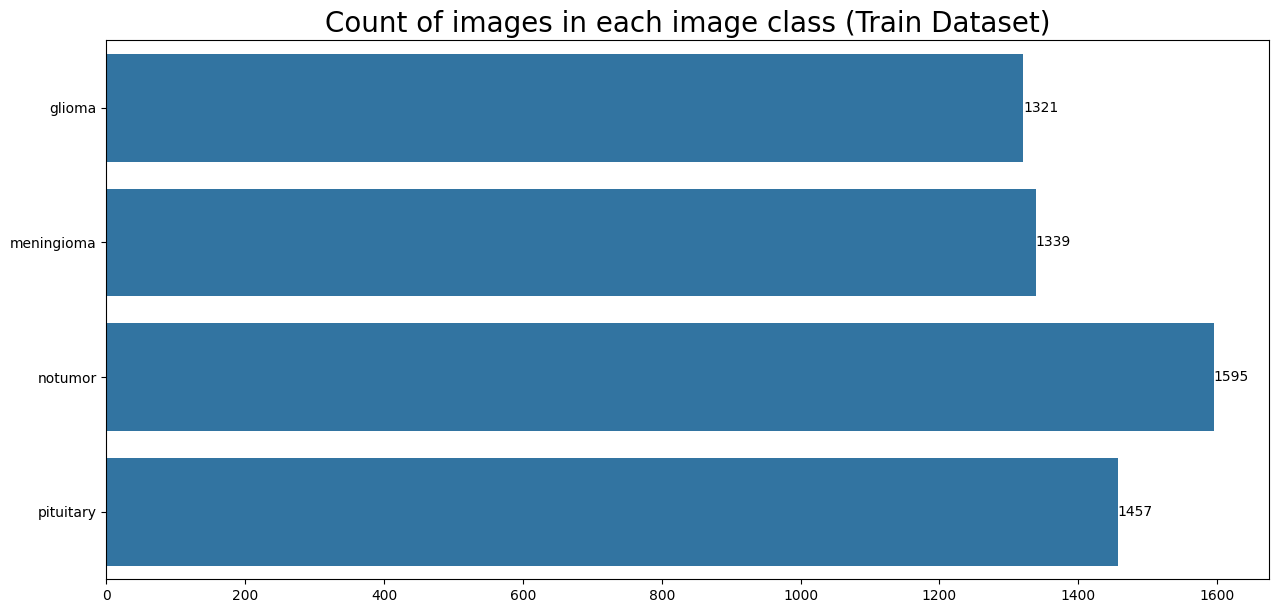

In [39]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Image_Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each image class (Train Dataset)', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

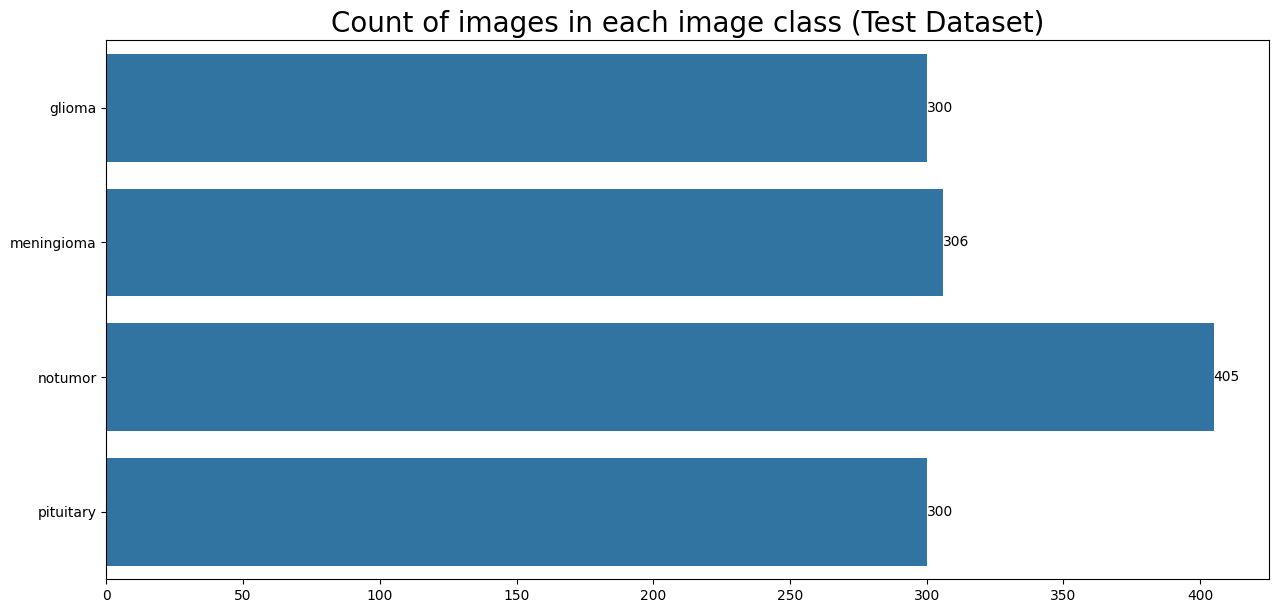

In [40]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_df , y=test_df['Image_Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each image class (Test Dataset)', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()